<a href="https://colab.research.google.com/github/sgcbayli024/Assignments/blob/main/Conor_Bayliss_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Firstly, let us import the code from the provided file dp_algos.py

In [1]:
!pip install quantecon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 3.1 MB/s eta 0:00:00


In [2]:
import jax

In [3]:
import numpy as np
import jax.numpy as jnp

In [4]:
import matplotlib.pyplot as plt

In [5]:
import quantecon as qe
import numpy as np
from collections import namedtuple
from numba import njit, prange, int32

Value Function Iteration

In [285]:
def value_function_iteration(v_init,
                             T,
                            get_greedy,
                             tolerance=1e-6,        # Error tolerance
                             max_iter=10_000,       # Max iteration bound
                             print_step=25,         # Print at multiples
                             verbose=True,
                             usejax=False):
    """
        Compute v_star via VFI and then compute greedy.
    """
    array_lib = jnp if usejax else np

    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        v_new = T(v)
        error = array_lib.max(array_lib.abs(v_new - v))
        if verbose and (k % print_step) == 0:
            print(f"Completed iteration {k} with error {error}.")
        v = v_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    v_star = v
    σ_star = get_greedy(v_star)
    return v_star, σ_star

Optimistic Policy Iteration

In [247]:
def optimistic_policy_iteration(v_init,
                                T_σ,
                                #model,
                                get_greedy,
                                tolerance=1e-6,
                                max_iter=1_000,
                                print_step=10,
                                m=60,
                                usejax=False):
    "Optimistic policy iteration routine."

    array_lib = jnp if usejax else np
    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k < max_iter:
        last_v = v
        σ = get_greedy(v)
        for i in range(m):
            #v = T_σ(v, σ)
            v = T_σ(v, σ)
        error = array_lib.max(array_lib.abs(v - last_v))
        if k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    return v, get_greedy(v)

Howard Policy Iteration

In [249]:
def howard_policy_iteration(v_init,
                            #model,
                            get_value,
                            get_greedy,
                            usejax=False):
    "Howard policy iteration routine."
    array_lib = jnp if usejax else np

    σ = get_greedy(v_init)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ)
        σ_new = get_greedy(v_σ)
        error = array_lib.max(array_lib.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        print(f"Concluded loop {i} with error {error}.")
    return v_σ, σ

Next, let us import the code from the provided file model.py. Note that I have added @jax.jit to all function definitions.

In [250]:

def f(y, a, d):
    " Inventory update rule. "
    return jnp.maximum(y - d, 0) + a

In [251]:
# NamedTuple to hold model parameters
Params = namedtuple(
         "Params", ("K", "c", "κ", "p"))

In [252]:

def build_R(params, y_vals, d_vals, ϕ_vals):
    " Build the R array using loops. "
    K, c, κ, p = params
    n_y = K + 1
    R = jnp.zeros((n_y, n_y, n_y))
    for y in y_vals:
        for yp in y_vals:
            for a in range(n_y - y):
                hits = f(y, a, d_vals) == yp
                R[y, a, yp] = jnp.sum(hits * ϕ_vals)
    return R

In [253]:

def build_R_vectorized(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    # Create R[y, a, yp, d] and then sum out last dimension
    y  = jnp.reshape(y_vals, (n_y, 1, 1, 1))
    a  = jnp.reshape(y_vals, (1, n_y, 1, 1))
    yp = jnp.reshape(y_vals, (1, 1, n_y, 1))
    d  = jnp.reshape(d_vals, (1, 1, 1, n_d))
    ϕ  = jnp.reshape(ϕ_vals, (1, 1, 1, n_d))
    feasible = a <= K - y
    temp = (f(y, a, d_vals) == yp) * feasible
    R = np.sum(temp * ϕ_vals, axis=3)
    return R

In [254]:

def build_r(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    r = jnp.full((n_y, n_y), -jnp.inf)
    for y in y_vals:
        revenue = jnp.sum(jnp.minimum(y, d_vals) * ϕ_vals)
        for a in range(n_y - y):
            cost = c * a + κ * (a > 0)
            r[y, a] = revenue - cost
    return r

In [255]:

def build_r_vectorized(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    y = jnp.reshape(y_vals, (n_y, 1))
    d = jnp.reshape(d_vals, (1, n_d))
    ϕ = jnp.reshape(ϕ_vals, (1, n_d))
    revenue = jnp.minimum(y, d) * ϕ
    exp_revenue = jnp.sum(revenue, axis=1)
    exp_revenue = jnp.reshape(exp_revenue, (n_y, 1))
    a = jnp.reshape(y_vals, (1, n_y))
    cost = c * a + κ * (a > 0)
    exp_profit = exp_revenue - cost
    feasible = a <= K - y
    r = jnp.where(feasible, exp_profit, -jnp.inf)
    return r

In [256]:
# NamedTuple to hold arrays used to solve model
Arrays = namedtuple(
         "Arrays", ("r", "R", "y_vals", "z_vals", "Q"))

In [257]:
# NamedTuple to store parameters, array sizes, and arrays
Model = namedtuple("Model", ("params", "sizes", "arrays"))

In [258]:

def create_sdd_inventory_model(ρ=0.98,        # Z persistence
                               ν=0.002,       # Z volatility
                               n_z=25,        # size of Z grid
                               b=0.97,        # Z mean
                               K=100,         # max inventory
                               d_max=100,     # max value of d
                               c=0.2,         # unit cost
                               κ=0.8,         # fixed cost
                               p=0.6):        # demand parameter

    n_y = K + 1               # size of state space
    y_vals = jnp.arange(n_y)   # inventory levels 0,...,K

    # Construct r and R arrays
    def ϕ(d):
        return (1 - p)**d * p
    d_vals = jnp.arange(d_max)
    ϕ_vals = ϕ(d_vals)

    # Build the exogenous discount process
    mc = qe.tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values + b, mc.P
    ρL = jnp.max(jnp.abs(jnp.linalg.eigvals(z_vals * Q)))
    if ρL >= 1:
        raise NotImplementedError("Error: ρ(L) ≥ 1.")
    else:
        print(f"Building model with ρ(L) = {ρL}")

    # Build namedtuples and return them
    params = Params(K=K, c=c, κ=κ, p=p)
    r = build_r_vectorized(params, y_vals, d_vals, ϕ_vals)
    R = build_R_vectorized(params, y_vals, d_vals, ϕ_vals)

    arrays = Arrays(r=r, R=R, y_vals=y_vals, z_vals=z_vals, Q=Q)
    sizes = n_y, n_z
    return Model(params=params, sizes=sizes, arrays=arrays)

Next, import the code from the file plot_code.py

In [315]:

def sim_inventories(model, σ_star, ts_length, Y_init=0, seed=500):
    """
        Simulate inventory dynamics and interest rates given an
        optimal policy σ_star.
    """
    # Set up
    np.random.seed(seed)
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays

    # Generate Markov chain for discount factor
    z_mc = qe.MarkovChain(Q, z_vals)
    i_z = z_mc.simulate_indices(ts_length, init=1, random_state=seed)

    # Generate corresponding inventory series
    Y = np.zeros(ts_length, dtype=int)
    Y[0] = Y_init
    for t in range(ts_length - 1):
        D = np.random.geometric(p) - 1
        a = σ_star[Y[t], i_z[t]]
        Y[t+1] = f(Y[t],  a,  D)

    # Return both series
    return Y, z_vals[i_z]

In [316]:

def plot_ts(model,
            σ_star,
            ts_length=400,
            fontsize=12,
            figname="ts.pdf",
            savefig=False):
    """
        Solve model, plot a time series of inventory and interest rates.

    """

    # Obtain inventory and discount factor series
    Y, Z = sim_inventories(model, σ_star, ts_length)
    r = (1 / Z) - 1 # calculate interest rate from discount factors

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))
    ax = axes[0]
    ax.plot(Y, label="inventory", alpha=0.7)
    ax.set_xlabel("time", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, jnp.max(Y)+3)
    ax = axes[1]
    ax.plot(r, label="$r_t$", alpha=0.7)
    ax.set_xlabel("$t$", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    plt.tight_layout()
    plt.show()
    if savefig:
        fig.savefig(figname)

In [318]:

def plot_timing(hpi_time,
                vfi_time,
                opi_times,
                m_vals,
                figname="timing.pdf",
                fontsize=12,
                savefig=False):
    """
    Plot relative timing of different algorithms.

    """
    fig, ax = plt.subplots(figsize=(9, 5.2))

    y_values = (np.full(len(m_vals), vfi_time),
                np.full(len(m_vals), hpi_time),
                opi_times)
    labels = "VFI", "HPI", "OPI"

    for y_vals, label in zip(y_values, labels):
        ax.plot(m_vals, y_vals, lw=2, label=label)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_xlabel("$m$", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    plt.show()

    if savefig:
        fig.savefig(figname)

In [262]:
f = jax.jit(f)

In [312]:

def B(v, params, sizes, arrays):
    """
    B(y, a, v) = r(y, a) + β(z) Σ_{y′, z′} v(y′, z′) R(y, a, y′) Q(z, z′)

    Jax implementation
    """
    # Set up
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    #I, J =len(y_vals) , len(z_vals)
    #Reshape and broadcast over (i, j, i, i', j')
    #Reshape and broadcast over (y, z, a, y', z')
    Q  = jnp.reshape(Q,         (1, n_z, 1, 1, n_z))
    R  = jnp.reshape(R,         (n_y, 1, n_y, n_y, 1))
    v  = jnp.reshape(v,         (1, 1, 1, n_y, n_z))

    EV = jnp.sum(v*R*Q, axis=(3, 4))
    #Now, reshape and broadcast over  (y, z, a)
    β  = jnp.reshape(z_vals, (1, n_z, 1))
    r  = jnp.reshape(r,      (n_y, 1, n_y))
    return r + β * EV

In [264]:

def T(v, params, sizes, arrays):
    """The Bellman operator."""
    return jnp.max(B(v, params, sizes, arrays), axis=2)

In [265]:
model = create_sdd_inventory_model()

n_y, n_z = model.sizes
v = jnp.zeros((n_y, n_z))
vp = T(v, model.params, model.sizes, model.arrays)

Building model with ρ(L) = 0.9751706719398499


In [266]:
vp.shape

(101, 25)

In [291]:

def compute_r_σ(σ, params, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack model
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    z_idx=jnp.arange(n_z)
    #z_idx=jnp.arange(z_vals)
    #I, J =len(y_vals) , len(z_vals)
    #N = I * J
    # Compute r_σ[i, j]
    y = jnp.reshape(y_vals, (n_y, 1))
    z = jnp.reshape(z_idx, (1, n_z))
    r_σ = r[y, σ[y,z]]

    return r_σ

In [292]:

def compute_R_σ(σ, params, sizes, arrays):
    """
    Compute the array r_σ[i, j] = r[i, j, σ[i, j]], which gives current
    rewards given policy σ.
    """

    # Unpack model
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    z_idx=jnp.arange(n_z)
    #z_idx=jnp.arange(z_vals)
    #I, J =len(y_vals), len(z_vals)
    #N = I * J
    # Compute r_σ[i, j]
    y = jnp.reshape(y_vals, (n_y, 1, 1))
    z = jnp.reshape(z_idx, (1, n_z, 1))
    yp = jnp.reshape(y_vals, (1, 1, n_y))
    R_σ = R[y, σ[y,z], yp]

    return R_σ

In [304]:
def compute_L_σ(σ, params, sizes, arrays):
    #load in the necessary parameters
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = model.sizes
    R_σ=compute_R_σ(σ, params, sizes, arrays)
    #I, J =len(y_vals) , len(z_vals)
    #N = I * J
    #z_idx=jnp.arange(n_z)
    # broadcast over (y,   z,   y',  z')
    β = jnp.reshape(z_vals, (1, n_z, 1, 1))
    R_σ=jnp.reshape(R_σ, (n_y, n_z, n_y, 1))
    Q=jnp.reshape(Q, (1, n_z, 1, n_z))
    #compute L_σ
    L_σ=β*R_σ*Q
    return L_σ

In [224]:

def get_greedy(v, params, sizes, arrays):
    "Computes a v-greedy policy, returned as a set of indices."
    return jnp.argmax(B(v, params, sizes, arrays), axis=2)

In [306]:

def T_σ(v, σ, params, sizes, arrays):
    "The policy operator."
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    n_y, n_z = len(y_vals) , len(z_vals)
    #I, J =len(y_vals) , len(z_vals)
   # N = I * J

    r_σ = compute_r_σ(σ, params, sizes, arrays)
    L_σ = compute_L_σ(σ, params, sizes, arrays)
    v = jnp.reshape(v, (1, 1, n_y, n_z))
    return r_σ + jnp.sum(v * L_σ, axis=(2, 3))

In [243]:

def get_value(σ, params, sizes, arrays):
    # Unpack
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays
    #n_y, n_z = model.sizes
    n_y, n_z =len(y_vals) , len(z_vals)
    N = n_y * n_z
    #Load in r_sigma and L_sigma
    r_σ = compute_r_σ(σ, params, sizes, arrays)
    L_σ = compute_L_σ(σ, params, sizes, arrays)
    #Reshape and broadcast over (N,N)
    L_σ=jnp.reshape(L_σ, (N,N))
    r_σ=jnp.reshape(r_σ, N)
    #Create an identity matrix, Id of size N
    Id = jnp.identity(N)
    #Solve for v_sigma
    v_σ=jnp.linalg.solve(Id - L_σ, r_σ)
    #Reshape back into (y,z)
    return jnp.reshape(v_σ, (n_y,n_z))

In [268]:
## Custom solvers

def solve_model_jax(model, algorithm="OPI", **kwargs):
    """
    General purpose solver.

    algorithm : OPI, VFI or HPI

    """

    # Set up
    params, sizes, arrays = model
    n_y, n_z = model.sizes
    v_init = jnp.zeros((n_y, n_z))

    # Solve
    print(f"Solving model using {algorithm}.")
    match algorithm:
        case "OPI":
            solver = optimistic_policy_iteration
            args = (v_init,
                #lambda v, σ: T_σ(v, σ, model),
                lambda v, σ: T_σ(v, σ, params, sizes, arrays),
                #lambda v: get_greedy(v, model)
                lambda σ: get_greedy(σ, params, sizes, arrays))
        case "HPI":
            solver = howard_policy_iteration
            args = (v_init,
                #lambda σ: get_value(σ, model)
                lambda σ: get_value(σ, params, sizes, arrays),
                #lambda v: get_greedy(v, model)
                lambda v: get_greedy(v, params, sizes, arrays))
        case "VFI":
            solver = value_function_iteration
            args = (v_init,
                #lambda v: T(v, model)
                lambda v: T(v, params, sizes, arrays),
                #lambda v: get_greedy(v, model)
                lambda v: get_greedy(v, params, sizes, arrays))
        case _:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    kwargs['usejax'] = True
    v_star, σ_star = solver(*args, **kwargs)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [269]:

def test_timing_jax(model,
                      m_vals=range(1, 100, 20),
                      figname="numba_timing.pdf",
                      savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_jax(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_jax(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = jnp.max(jnp.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_jax(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = jnp.max(jnp.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time,
                vfi_time,
                opi_times,
                m_vals,
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

Now, let's solve.

In [293]:
B = jax.jit(B, static_argnums=(2,))

In [294]:
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))

In [295]:
compute_R_σ = jax.jit(compute_R_σ, static_argnums=(2,))

In [296]:
compute_L_σ = jax.jit(compute_L_σ, static_argnums=(2,))

In [297]:
T = jax.jit(T, static_argnums=(2,))

In [298]:
T_σ = jax.jit(T_σ, static_argnums=(3,))

In [299]:
get_greedy = jax.jit(get_greedy, static_argnums=(2,))

In [300]:
get_value = jax.jit(get_value, static_argnums=(2,))

In [301]:
model = create_sdd_inventory_model()

Building model with ρ(L) = 0.9751706719398499


In [286]:
### Solve by VFI

v_star, σ_star = solve_model_jax(model, algorithm="VFI")

Solving model using VFI.
Completed iteration 25 with error 0.5612945556640625.
Completed iteration 50 with error 0.3776073455810547.
Completed iteration 75 with error 0.227813720703125.
Completed iteration 100 with error 0.12967300415039062.
Completed iteration 125 with error 0.06840896606445312.
Completed iteration 150 with error 0.03108978271484375.
Completed iteration 175 with error 0.014713287353515625.
Completed iteration 200 with error 0.00772857666015625.
Completed iteration 225 with error 0.004138946533203125.
Completed iteration 250 with error 0.0022125244140625.
Completed iteration 275 with error 0.001186370849609375.
Completed iteration 300 with error 0.00063323974609375.
Completed iteration 325 with error 0.00034332275390625.
Completed iteration 350 with error 0.00018310546875.
Completed iteration 375 with error 9.918212890625e-05.
Completed iteration 400 with error 5.7220458984375e-05.
Completed iteration 425 with error 3.4332275390625e-05.
Completed iteration 450 with err

In [308]:
### Solve by HPI

v_star, σ_star = solve_model_jax(model, algorithm="HPI")

Solving model using HPI.
Concluded loop 1 with error 66.
Concluded loop 2 with error 60.
Concluded loop 3 with error 32.
Concluded loop 4 with error 32.
Concluded loop 5 with error 24.
Concluded loop 6 with error 24.
Concluded loop 7 with error 24.
Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:19.33
Solved model using HPI in 19.33383 seconds.


In [307]:
### Solve by OPI

v_star, σ_star = solve_model_jax(model, algorithm="OPI")

Solving model using OPI.
Completed iteration 10 with error 0.003993988037109375.
TOC: Elapsed: 0:00:56.62
Solved model using OPI in 56.62271 seconds.


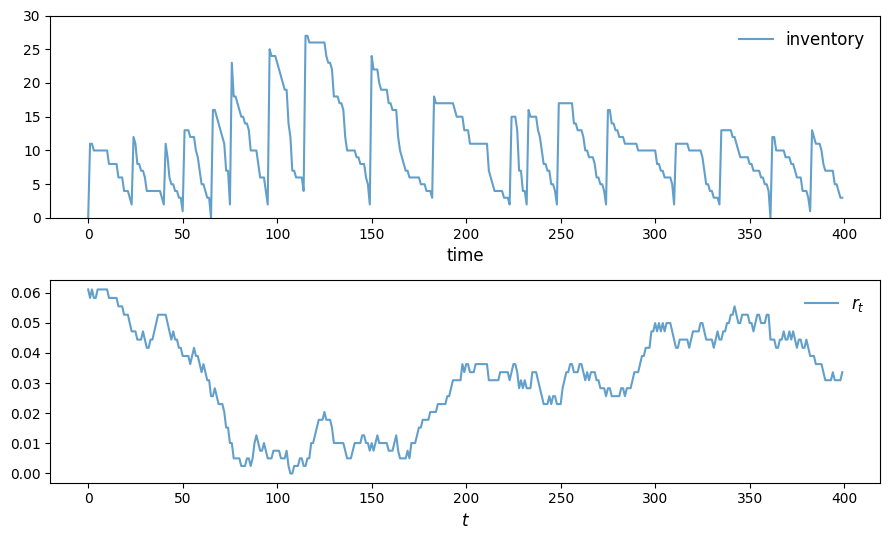

In [319]:
plot_ts(model, σ_star, figname="jax_ts.pdf", savefig=False)

In [310]:
### Test timing

hpi_time, vfi_time, opi_times = test_timing_jax(model)

Solving model using HPI.
Concluded loop 1 with error 66.
Concluded loop 2 with error 60.
Concluded loop 3 with error 32.
Concluded loop 4 with error 32.
Concluded loop 5 with error 24.
Concluded loop 6 with error 24.
Concluded loop 7 with error 24.
Concluded loop 8 with error 0.
TOC: Elapsed: 0:00:18.64
Solved model using HPI in 18.64748 seconds.
TOC: Elapsed: 0:00:18.64
Solving model using VFI.
Completed iteration 25 with error 0.5612945556640625.
Completed iteration 50 with error 0.3776073455810547.
Completed iteration 75 with error 0.227813720703125.
Completed iteration 100 with error 0.12967300415039062.
Completed iteration 125 with error 0.06840896606445312.
Completed iteration 150 with error 0.03108978271484375.
Completed iteration 175 with error 0.014713287353515625.
Completed iteration 200 with error 0.00772857666015625.
Completed iteration 225 with error 0.004138946533203125.
Completed iteration 250 with error 0.0022125244140625.
Completed iteration 275 with error 0.0011863708

KeyboardInterrupt: ignored